In [1]:
import os
from importlib.resources import files
import time

import copy
import numpy as np
import torch
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# enable LaTeX rendering and font family
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times'

from learn_embedding.approximators import *
from learn_embedding.covariances import *
from learn_embedding.kernels import SquaredExp
from learn_embedding.embedding import Embedding
from learn_embedding.dynamics import FirstGeometry, SecondGeometry, LinearField
from learn_embedding.utils import *
from learn_embedding.loss import *
from learn_embedding.utils.plotting import *
from learn_embedding.utils.metrics import metric_exp

In [2]:
# problem dimension
dim = 2
# Total number of trajectories
num_traj = 7
# Number of trajectories used for training
num_train = 4
# Desired number of samples per trajectory
num_samples = 1000
# load model
load_model = True
# train model
train_model = False
# save model
save_model = False
# simulate flat space model
flat_space = False
# Flat space away from the demonstration
embedding_bump = False
# sample test trajectories randomly in the space
random_traj = True
# showcase obstacle avoidance
obstacle_avoidance = False

## Load Dataset

In [3]:
train_x, train_y = np.empty((0, 2)), np.empty((0, 2))
test_x, test_y = [], []

for i in range(1, num_traj + 1):
    # Load trajectory data
    data = np.loadtxt("../learn_embedding/data/synthetic/trajectory_" + str(i) + ".csv")

    # remove last point
    data = data[:-1,:]

    # subsample
    idx = DataProcess.subsample(data[:,:2], num_samples)

    # center
    data[idx,:2] -= data[-1,:2]
    
    # zero velocity last sample
    data[-1,2:4] = np.zeros(2)
    
    # add to datset
    if i <= num_train:
        train_x = np.append(train_x, data[idx,:2], axis=0)
        train_y = np.append(train_y, data[idx,2:4], axis=0)
    else:
        test_x.append(data[idx,:2])
        test_y.append(data[idx,2:4])

## Torch Configuration

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_x = torch.from_numpy(train_x).float().to(device).requires_grad_(True)
train_y = torch.from_numpy(train_y).float().to(device)

## Create Model

In [5]:
torch.manual_seed(1337)

# approximator = KernelExpansion(train_x[:, :dim])
# approximator = KernelMachine(dim, 1000, 1, length=0.4)
num_neurons = [64]
num_layers = 2
approximator = FeedForward(dim, num_neurons*num_layers, 1)

embedding = Embedding(approximator)

stiffness = SPD(dim)
# stiffness = Spherical()

attractor = train_x[-1][:2].detach()

model = FirstGeometry(embedding, attractor, stiffness,).to(device)

if load_model:
    TorchHelper.load(model, '../models/synthetic_first', device)

## Train

In [6]:
if train_model:
    model.train()
    num_epochs = 5000
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=200, 
                                                           threshold=1e-3, threshold_mode='rel', cooldown=0, 
                                                           min_lr=0, eps=1e-8, verbose=True)
    loss_fun = torch.nn.MSELoss()
    loss_log = []
    
    t0 = time.time()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(train_x)
        loss = loss_fun(pred,train_y)
        loss_log.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

    print("Time: ", time.time()-t0)
    print("Loss: ", loss.item())
    
    loss_log = np.array(loss_log)
    fig, ax = plt.subplots(figsize=(6, 6))
    init_epoch = 0
    ax.plot(np.arange(num_epochs)[init_epoch:], loss_log[init_epoch:])
    fig.tight_layout()
    fig.savefig('../media/synthetic_first_loss.png', format='png', dpi=100, bbox_inches="tight")

if save_model:
    TorchHelper.save(model, '../models/synthetic_first')

## Test

In [7]:
%%capture
if flat_space:
    TorchHelper.set_zero(model)
if embedding_bump:
    embedding.bump = BumpKNN(train_x, 0.15, 0.01)
if obstacle_avoidance:
    obstacle_radius = 0.05 # 0.05 , 0.1
    obstacle = torch.tensor([[0.25,0.4]])
    # obstacle = Obstacles.square(center=torch.tensor([-30,20]), a=20, b=20, res=10)
    # obstacle = Obstacles.semi_circle(radius=0.2, center=torch.tensor([-0.4,   -0.4]), rot=torch.tensor(torch.pi/4), res=50)
    decay = 5e-1
    lengthscale = np.sqrt(-0.5*obstacle_radius**2/np.log(decay))
    # phi = KernelExpansion(obstacle.to(device), kernel=SquaredExp(l=lengthscale)).to(device)
    # embedding.local_deformation = KernelDeformation(obstacle.to(device), weights=torch.ones(obstacle.shape[0]).to(device), kernel=SquaredExp(l=lengthscale), tol=-0.05).to(device)
    # embedding.metric = lambda y : metric_exp(y, embedding(obstacle.to(device)).squeeze(), sigma=lengthscale, eta=1.0)
model.eval()

In [35]:
# plot options
resolution = 100
std = train_x.detach().std(axis=0)
min_ax = train_x.detach().min(axis=0)[0] - 3*std/2
max_ax = train_x.detach().max(axis=0)[0] + 3*std/2
length = max_ax - min_ax
diff = length.max() - length.min()
min_ax[length.argmin()] -= diff/2
max_ax[length.argmin()] += diff/2
step_scatter = 20

# grids
x, y = torch.meshgrid(torch.linspace(min_ax[0], max_ax[0], resolution), torch.linspace(min_ax[1], max_ax[1], resolution), indexing='xy')
grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
grid_xr = torch.stack((torch.ravel(x[10::10,10::10]), torch.ravel(y[10::10,10::10])), dim=1).to(device).requires_grad_(True)
theta = torch.linspace(0, 2*torch.pi, steps=50).to(device)

### Potential

In [36]:
potential = model.potential(grid_x).reshape(resolution, -1).cpu().detach().numpy()
evals = stiffness.eigval.data.exp()
evecs = stiffness.eigvec.data
U, _ = torch.linalg.qr(torch.cat((evecs.unsqueeze(1), torch.rand(evecs.shape[0], evecs.shape[0]-1).to(device)), dim=1))
stiffness_ellipse = torch.stack((evals[0]*theta.cos(), evals[1]*theta.sin()), dim=1)
stiffness_ellipse = torch.mm(U, stiffness_ellipse.T).T.detach().cpu()/10
# print("Stiffness Evals: ", evals)
# print("Stiffness Evecs: ", evecs)

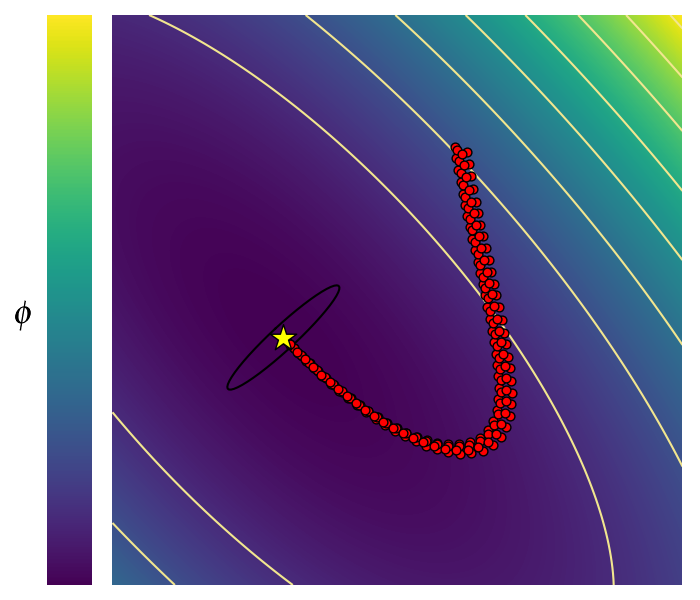

In [37]:
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.contourf(x, y, potential, 500, cmap="viridis")
ax.contour(x, y, potential, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::step_scatter, 0], train_x.cpu().detach()[::step_scatter, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
ax.plot(stiffness_ellipse[:,0], stiffness_ellipse[:,1], c='k')
colorbar(im, fig, ax, label='\phi', size='8%')
beautify(fig, ax)
fig.savefig('../media/synthetic_first_potential.png', format='png', dpi=100, bbox_inches="tight")

### Vector Field & Streamlines 

In [38]:
field = model(grid_x)
x_field = field[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_field = field[:, 1].reshape(resolution, -1).cpu().detach().numpy()

In [39]:
if random_traj:
    x0 = TorchHelper.grid_uniform(torch.tensor([1.2, 0.8]), torch.tensor([0.01, 0.01]), samples=1).to(device).requires_grad_(True)
else:
    x0 = np.empty((0, 2))
    for traj in test_x:
        x0 = np.append(x0, traj[0][np.newaxis, :], axis=0)
    x0 = torch.from_numpy(x0).float().to(device).requires_grad_(True)
streamlines = Integrator.first_order(dynamics=model,x0=x0,T=20.0, dt=0.01).cpu().detach().numpy()

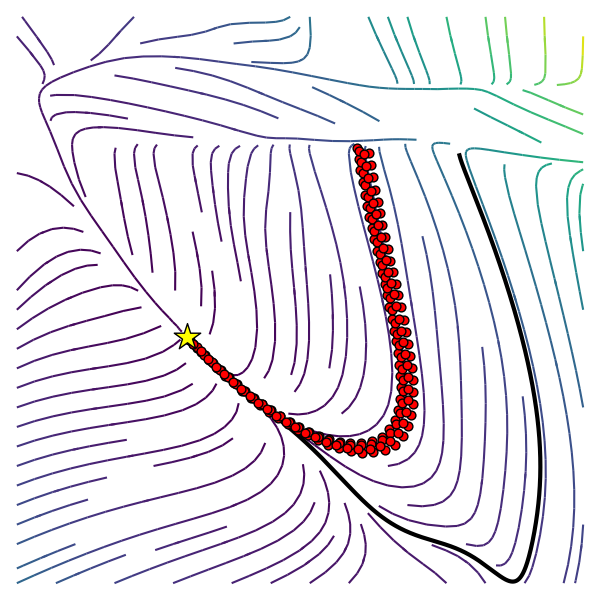

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.streamplot(x.numpy(), y.numpy(), x_field, y_field, color=potential, cmap="viridis", linewidth=1.5, arrowstyle='-', arrowsize=1.5)
ax.scatter(train_x.cpu().detach()[::step_scatter, 0], train_x.cpu().detach()[::step_scatter, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=10)
for i in range(streamlines.shape[1]):
    ax.plot(streamlines[:, i, 0], streamlines[:, i, 1], color='k', linewidth=3.0)
if hasattr(embedding, 'local_deformation'):
    for i in range(0,obstacle.shape[0],4):
        circ = plt.Circle((obstacle[i, 0], obstacle[i, 1]), obstacle_radius-0.02,color='k', fill='grey', alpha=0.5)
        ax.add_patch(circ)
# colorbar(im, fig, ax, label='\phi', size='8%')
beautify(fig, ax)
fig.savefig('../media/synthetic_first_field.png', format='png', dpi=100, bbox_inches="tight") 

### Embedding

In [42]:
grid_embedding = embedding(grid_x)
x_embedding = grid_embedding[:, 0].reshape(resolution, -1).cpu().detach().numpy()
y_embedding = grid_embedding[:, 1].reshape(resolution, -1).cpu().detach().numpy()
z_embedding = grid_embedding[:, 2].reshape(resolution, -1).cpu().detach().numpy()
train_embedding = embedding(train_x[:,:dim]).cpu().detach().numpy()
test_embedding = []
for i in range(streamlines.shape[1]):
    test_embedding.append(embedding(torch.from_numpy(streamlines[:,i,:dim]).float().to(device).requires_grad_(True)).cpu().detach().numpy())
attractor_embedding = embedding(attractor.unsqueeze(0)).squeeze().cpu().detach().numpy()

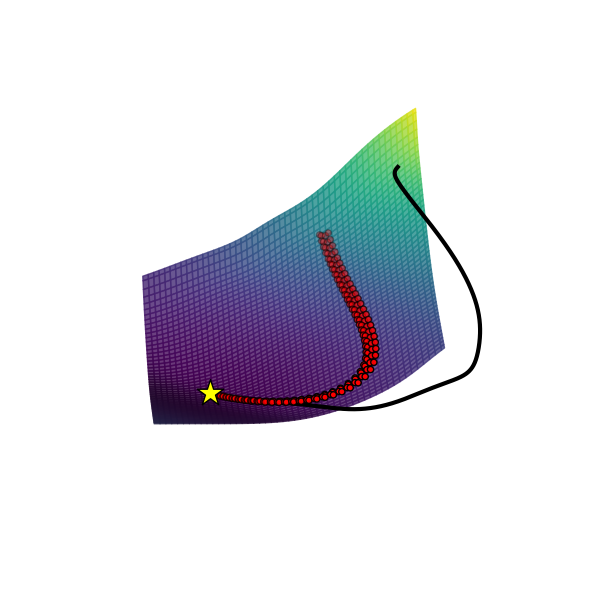

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)
norm = plt.Normalize(vmin=potential.min(), vmax=potential.max())
colors = plt.cm.viridis(norm(potential))
im = ax.plot_surface(x_embedding, y_embedding, z_embedding, edgecolor='none', antialiased=True, alpha=0.8, facecolors=colors)
ax.scatter(train_embedding[::step_scatter, 0], train_embedding[::step_scatter, 1], train_embedding[::step_scatter, 2], s=20, edgecolors='k', c='red', zorder=10)
for traj in test_embedding:
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='k', linewidth=3.0)
ax.scatter(attractor_embedding[0], attractor_embedding[1], attractor_embedding[2], s=400, edgecolors='k', c='yellow', marker="*", zorder=10)
ax.axis('off')
ax.view_init(elev=30, azim=-95)
fig.patch.set_visible(False)
fig.tight_layout()
fig.savefig('../media/synthetic_first_embedding.png', format='png', dpi=100, bbox_inches="tight")
# mappable = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
# cbar.set_label('$\phi$', fontsize=24, rotation=0, labelpad=10)
# cbar.ax.set_yticklabels([])
# cbar.ax.tick_params(length=0)
# cbar.outline.set_visible(False)  # Remove colorbar frame

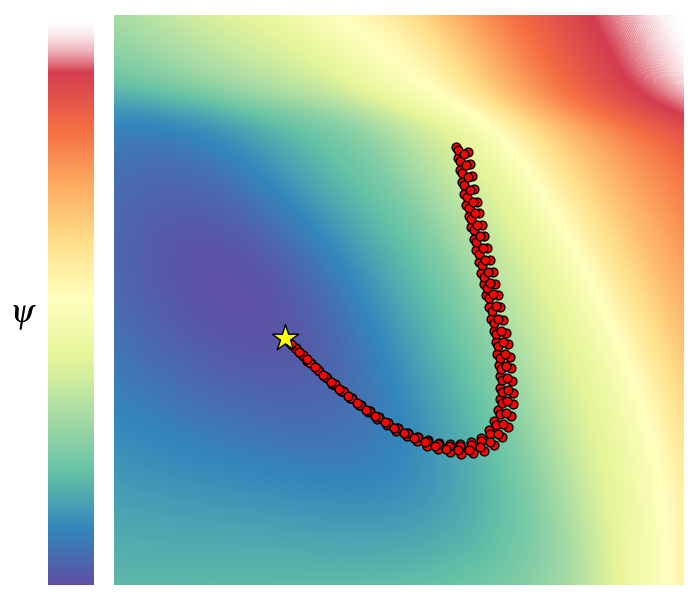

In [43]:
fig, ax = plt.subplots(figsize=(7, 6))
cmap = colormap_right("Spectral_r")
im = ax.contourf(x_embedding, y_embedding, z_embedding, 500, cmap=cmap)
# ax.contour(x_embedding, y_embedding, z_embedding, 10, cmap=None, colors='#f2e68f')
ax.scatter(train_x.cpu().detach()[::step_scatter, 0], train_x.cpu().detach()[::step_scatter, 1], s=40, edgecolors='k', c='red', zorder=10)
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
# ax.plot(stiffness_ellipse[:,0], stiffness_ellipse[:,1], c='k')
colorbar(im, fig, ax, label='\psi', size='8%')
beautify(fig, ax)
fig.savefig('../media/synthetic_first_psi.png', format='png', dpi=100, bbox_inches="tight")

### Metric

In [17]:
metric = model.embedding.pullmetric(grid_embedding, model.embedding.jacobian(grid_x, grid_embedding))
det_metric = metric.det().reshape(resolution, -1).detach().cpu().numpy()

red_embedding = embedding(grid_xr)
metric_r = embedding.pullmetric(red_embedding, embedding.jacobian(grid_xr, red_embedding))
evals,evecs = torch.linalg.eigh(metric_r)
evals /= 500*torch.tensor([0.1,1.0]).to(device)
# evals /= 40
ellipses = torch.stack((evals[:, 0].unsqueeze(-1)*theta.cos(), evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
ellipses = torch.bmm(evecs, ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
ellipses_x = x[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 0]
ellipses_y = y[10::10,10::10].ravel().unsqueeze(-1) + ellipses[:, :, 1]

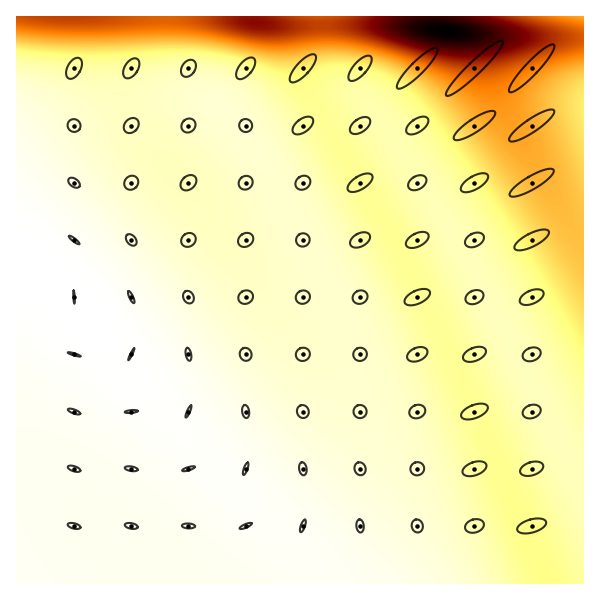

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.contourf(x, y, det_metric, 500, cmap="afmhot_r")
ax.scatter(x[10::10, 10::10], y[10::10, 10::10], color="k", s=5)
for i in range(ellipses.shape[0]):
    ax.plot(ellipses_x[i, :], ellipses_y[i, :], color="k", linewidth=1.5, alpha=0.8)
# colorbar(im, fig, ax, label='|G|', size='8%')
beautify(fig, ax)
fig.savefig('../media/synthetic_first_detmetric.png', format='png', dpi=100, bbox_inches="tight")

### Inverse Metric Ellispses on Streamlines

In [19]:
x_sampled = torch.from_numpy(streamlines[:, 0, :dim]).float().to(device).requires_grad_(True)
v_sampled = torch.from_numpy(streamlines[:, 0, dim:]).float().to(device).requires_grad_(True)
sampled_embedding = embedding(x_sampled)

metric_sampled = model.embedding.pullmetric(sampled_embedding, model.embedding.jacobian(x_sampled, sampled_embedding))
metric_evals,metric_evecs = torch.linalg.eigh(metric_sampled.inverse())
metric_evals/= 50*torch.tensor([0.1,1.0]).to(device)
# metric_evals /= 40

metric_ellipses = torch.stack((metric_evals[:, 0].unsqueeze(-1)*theta.cos(), metric_evals[:, 1].unsqueeze(-1)*theta.sin()), dim=2)
metric_ellipses = torch.bmm(metric_evecs, metric_ellipses.permute(0, 2, 1)).permute(0, 2, 1).detach().cpu()
step_metric = 150

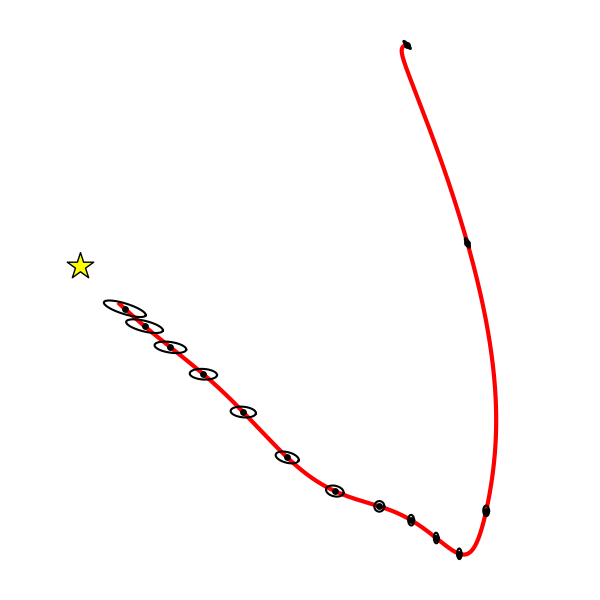

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x_sampled[:, 0].detach().cpu(), x_sampled[:, 1].detach().cpu(), color='r', linewidth='3')
ax.scatter(x_sampled[::step_metric, 0].detach().cpu(), x_sampled[::step_metric, 1].detach().cpu(), color="k", s=15, zorder=10)
for i in range(0, metric_ellipses.shape[0], step_metric):
    ax.plot(x_sampled[i, 0].detach().cpu() + metric_ellipses[i, :, 0],
            x_sampled[i, 1].detach().cpu() + metric_ellipses[i, :, 1], color="k", linewidth=1.5)    
ax.scatter(attractor[0].cpu(), attractor[1].cpu(), s=400, edgecolors='k', c='yellow', marker="*", zorder=20)
beautify(fig, ax)
fig.savefig('../media/synthetic_first_invmetric.png', format='png', dpi=100, bbox_inches="tight")